In [1]:
# COMP 551 - Assignment 2
# Asher Wright - 260559393
import numpy as np
import math
import matplotlib.pyplot as plt

#Q1: Creating our dataset

#read data from files
ds1_mean_neg = np.genfromtxt(open("Datasets/DS1_m_0.txt", "rb"), delimiter=",")
ds1_mean_pos = np.genfromtxt(open("Datasets/DS1_m_1.txt", "rb"), delimiter=",")
#remove all nan values (since extra comma at ends)
ds1_mean_neg = ds1_mean_neg[~np.isnan(ds1_mean_neg)]
ds1_mean_pos = ds1_mean_pos[~np.isnan(ds1_mean_pos)]
#generate and read in covariance matrix
ds1_cov = np.zeros((len(ds1_mean_neg), len(ds1_mean_neg)))

cov_count = 0
with open("Datasets/DS1_Cov.txt", "rb") as f:
    for line in f:
        values = line.split(",")[:-1] #remove '\n'
        ds1_cov[cov_count] = map(np.float, values)        
        cov_count +=1

#generate the 2000 examples for each, some test and some train
pos_test_examples = np.random.multivariate_normal(ds1_mean_pos, ds1_cov, size=600)
neg_test_examples = np.random.multivariate_normal(ds1_mean_neg, ds1_cov, size=600)
pos_train_examples = np.random.multivariate_normal(ds1_mean_pos, ds1_cov, size=1400)
neg_train_examples = np.random.multivariate_normal(ds1_mean_neg, ds1_cov, size=1400)

#TODO: figure out if they want four separate files (like in A1) or one file with labels inside
np.savetxt("Datasets/DS1_positive_testing", pos_test_examples, delimiter=',')
np.savetxt("Datasets/DS1_positive_training", pos_train_examples, delimiter=',')
np.savetxt("Datasets/DS1_negative_testing", neg_test_examples, delimiter=',')
np.savetxt("Datasets/DS1_negative_training", neg_train_examples, delimiter=',')

In [2]:
#Q2:
def calculate_LDA_params(pos_train, neg_train):
    #The parameters to estimate are pi, u1, u2, and sigma.
    N1 = len(pos_train)
    N2 = len(neg_train)
    #Max likelihood says pi = N1/(N1 + N2)
    pi = float(N1) / float(N1 + N2)
    #Max likelihood says ui = mean of all points of type i
    mu_1 = np.mean(pos_train, 0)
    mu_2 = np.mean(neg_train, 0)
    #Max likelihood says sigma = N1/N * S1 + N2/N * S2 where Si = 1/Ni* SUM[(X(n)-ui)(X(n)-ui)^T]

    #calculate S1 and S2 using the training examples
    S1 = np.cov(pos_train.T)
    S2 = np.cov(neg_train.T)
    #not really necessary since we know it's equal (and half and half)
    Sigma = (N1*S1)/(N1 + N2) + (N2 * S2)/(N1 + N2)

    Sigma_inv = np.linalg.inv(Sigma)
    #now calculate the parameters of the model
    w_param = np.matmul(Sigma_inv,(mu_1 - mu_2))
    #print(Sigma_inv)
    w_0_param = (-1)* np.matmul(np.matmul(mu_1.T,Sigma_inv), mu_1) / 2. + np.matmul(np.matmul(mu_2.T, Sigma_inv), mu_2) / 2. + np.log(pi/(1 - pi))
    return w_param, w_0_param

In [3]:
#We now have our w and w_0 from the training set. We will use it on the test set.
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def LDA_accuracy(w, w_0, pos_test, neg_test):
    wrongly_classified = 0.
    false_negatives = 0.
    true_positives = 0.
    false_positives = 0.
    true_negatives = 0.
    for val in pos_test:
        probability = sigmoid(np.matmul(w.T, val)+w_0)
        if(probability < 0.5):
            wrongly_classified +=1
            false_negatives +=1
        else:
            true_positives +=1

    for val in neg_test:
        probability = sigmoid(np.matmul(w.T, val)+w_0)
        if(probability > 0.5):
            wrongly_classified +=1
            false_positives +=1
        else:
            true_negatives +=1
    #compute accuracy calculations
    accuracy = (len(pos_test) + len(neg_test) - wrongly_classified)/(len(pos_test) + len(neg_test))
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f_measure = (2 * precision * recall)/(precision + recall)
    return accuracy, precision, recall, f_measure

#now call the methods
w, w_0 = calculate_LDA_params(pos_train_examples, neg_train_examples)
print(LDA_accuracy(w, w_0, pos_test_examples, neg_test_examples))
print(w)
print(w_0)

(0.9566666666666667, 0.9724137931034482, 0.94, 0.9559322033898304)
[-14.71783675   8.80345053   6.47987358   3.55552355  10.15517015
   4.14914496 -18.31249635  24.51818702  30.33091802  -9.01708266
  13.2480541   13.37113899 -16.70963234 -13.78906079   5.69519961
 -13.31643455 -30.93908326   6.80251193   1.37150708   5.31150738]
-27.9993734416


In [4]:
#Q3: K-NN
# go through the test set
# for each one, find the k nearest neighbours in the train set
# depending on whether there are more positive or negative, label the point as such.
# we choose k odd so that we don't have any ties.
def k_NN(pos_train, neg_train, pos_test, neg_test):
    all_train_examples = np.concatenate((pos_train, neg_train))
    accuracies = []
    precisions = []
    recalls = []
    f_measures = []
    ks = xrange(1, 149, 2)
    for k in ks:
        wrongly_classified = 0.
        false_negatives = 0.
        true_positives = 0.
        false_positives = 0.
        true_negatives = 0.

        #do our positive test examples first:
        for val in pos_test:
            #take the difference
            diff = all_train_examples - val
            norms = np.linalg.norm(diff, axis=1)
            lowest_indices = norms.argsort()[:k]
            pos_neighbours = 0.
            for ind in lowest_indices:
                if(ind < len(pos_train)):
                    pos_neighbours +=1.
            if pos_neighbours < float(k)/2:
                wrongly_classified +=1
                false_negatives +=1
            else:
                true_positives +=1

        #print((len(pos_test_examples) - wrongly_classified)/(len(pos_test_examples)))

        neg_wrong_class = 0.
        #Now do the same thing for the negative test examples
        #for val in neg_test_examples:
        for val in neg_test:
            #take the difference
            diff = all_train_examples - val
            norms = np.linalg.norm(diff, axis=1)
            lowest_indices = norms.argsort()[:k]
            pos_neighbours = 0.
            for ind in lowest_indices:
                if(ind < len(pos_train)):
                    pos_neighbours +=1.
            if pos_neighbours > float(k)/2:
                wrongly_classified +=1
                neg_wrong_class +=1
                false_positives +=1
            else:
                true_negatives +=1
        # now calculate the accuracy values for this k, and store them
        accuracy = (len(pos_test) + len(neg_test) - wrongly_classified)/(len(pos_test) + len(neg_test))
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f_measures.append((2 * precision * recall)/(precision + recall))
    return ks, accuracies, precisions, recalls, f_measures

def plot_K_NN(ks, f_measures):
    #now we can plot the data
    plt.plot(ks, f_measures, 'ro')
    plt.ylabel("F-measure")
    plt.xlabel("k value")
    plt.title("F-measure vs k value for DS1")
    max_f_measure = max(f_measures)
    max_k = f_measures.index(max_f_measure)
    print("The highest f1 measure occurs when k = " + str(ks[max_k]) + ", and is " + str(100*max_f_measure) + "%")
    plt.show()

The highest f1 measure occurs when k = 9, and is 55.3299492386%


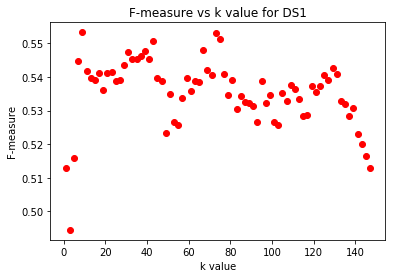

In [5]:
k_vals, accs, precs, recs, fs = k_NN(pos_train_examples, neg_train_examples, pos_test_examples, neg_test_examples)
plot_K_NN(k_vals, fs)

In [6]:
max_ind = np.argmax(fs)
print(accs[max_ind], precs[max_ind], recs[max_ind], fs[max_ind])

(0.56, 0.5618556701030928, 0.545, 0.5532994923857867)


In [7]:
#Q4 reading in data
ds2_mean_pos_1 = np.genfromtxt(open("Datasets/DS2_c1_m1.txt", "rb"), delimiter=",")
ds2_mean_pos_2 = np.genfromtxt(open("Datasets/DS2_c1_m2.txt", "rb"), delimiter=",")
ds2_mean_pos_3 = np.genfromtxt(open("Datasets/DS2_c1_m3.txt", "rb"), delimiter=",")
ds2_mean_neg_1 = np.genfromtxt(open("Datasets/DS2_c2_m1.txt", "rb"), delimiter=",")
ds2_mean_neg_2 = np.genfromtxt(open("Datasets/DS2_c2_m2.txt", "rb"), delimiter=",")
ds2_mean_neg_3 = np.genfromtxt(open("Datasets/DS2_c2_m3.txt", "rb"), delimiter=",")

# Remove nan values
ds2_mean_pos_1 = ds2_mean_pos_1[~np.isnan(ds2_mean_pos_1)]
ds2_mean_pos_2 = ds2_mean_pos_2[~np.isnan(ds2_mean_pos_2)]
ds2_mean_pos_3 = ds2_mean_pos_3[~np.isnan(ds2_mean_pos_3)]
ds2_mean_neg_1 = ds2_mean_neg_1[~np.isnan(ds2_mean_neg_1)]
ds2_mean_neg_2 = ds2_mean_neg_2[~np.isnan(ds2_mean_neg_2)]
ds2_mean_neg_3 = ds2_mean_neg_3[~np.isnan(ds2_mean_neg_3)]

#Read in all of the covariance matrices
ds2_cov1 = np.zeros((len(ds2_mean_pos_1), len(ds2_mean_pos_1)))
ds2_cov2 = np.zeros((len(ds2_mean_pos_2), len(ds2_mean_pos_2)))
ds2_cov3 = np.zeros((len(ds2_mean_pos_3), len(ds2_mean_pos_3)))

cov_count = 0
with open("Datasets/DS2_Cov1.txt", "rb") as f:
    for line in f:
        values = line.split(",")[:-1] #remove '\n'
        ds2_cov1[cov_count] = map(np.float, values)        
        cov_count +=1
    
cov_count = 0
with open("Datasets/DS2_Cov2.txt", "rb") as f:
    for line in f:
        values = line.split(",")[:-1] #remove '\n'
        ds2_cov2[cov_count] = map(np.float, values)        
        cov_count +=1

cov_count = 0
with open("Datasets/DS2_Cov3.txt", "rb") as f:
    for line in f:
        values = line.split(",")[:-1] #remove '\n'
        ds2_cov3[cov_count] = map(np.float, values)        
        cov_count +=1


In [8]:
# now that we've read in all our data we can generate our data set
# We will have 1200 test values and 2800 training values (same as before)
# Based on the probabilities: 0.1, 0.42, 0.48, we want [120 test & 280 train, 504 test & 1176 train, 576 & 1344 train]
# We are also going for half of each to be positive and half to be negative
pos_test_1_examples = np.random.multivariate_normal(ds2_mean_pos_1, ds1_cov, size=60)
neg_test_1_examples = np.random.multivariate_normal(ds2_mean_neg_1, ds1_cov, size=60)
pos_train_1_examples = np.random.multivariate_normal(ds2_mean_pos_1, ds1_cov, size=140)
neg_train_1_examples = np.random.multivariate_normal(ds2_mean_neg_1, ds1_cov, size=140)
pos_test_2_examples = np.random.multivariate_normal(ds2_mean_pos_2, ds1_cov, size=252)
neg_test_2_examples = np.random.multivariate_normal(ds2_mean_neg_2, ds1_cov, size=252)
pos_train_2_examples = np.random.multivariate_normal(ds2_mean_pos_2, ds1_cov, size=588)
neg_train_2_examples = np.random.multivariate_normal(ds2_mean_neg_2, ds1_cov, size=588)
pos_test_3_examples = np.random.multivariate_normal(ds2_mean_pos_3, ds1_cov, size=288)
neg_test_3_examples = np.random.multivariate_normal(ds2_mean_neg_3, ds1_cov, size=288)
pos_train_3_examples = np.random.multivariate_normal(ds2_mean_pos_3, ds1_cov, size=672)
neg_train_3_examples = np.random.multivariate_normal(ds2_mean_neg_3, ds1_cov, size=672)

#we now have all of our data in, we can combine it into one data set, with labels, to make it easier to handle.
positive_test_examples = np.concatenate((pos_test_1_examples,pos_test_2_examples,pos_test_3_examples))
negative_test_examples = np.concatenate((neg_test_1_examples,neg_test_2_examples,neg_test_3_examples))
positive_train_examples = np.concatenate((pos_train_1_examples,pos_train_2_examples,pos_train_3_examples))
negative_train_examples = np.concatenate((neg_train_1_examples,neg_train_2_examples,neg_train_3_examples))

np.savetxt("Datasets/DS2_positive_testing", positive_test_examples, delimiter=',')
np.savetxt("Datasets/DS2_positive_training", positive_train_examples, delimiter=',')
np.savetxt("Datasets/DS2_negative_testing", negative_test_examples, delimiter=',')
np.savetxt("Datasets/DS2_negative_training", negative_train_examples, delimiter=',')

In [9]:
# now we can do LDA on the data set
w, w_0 = calculate_LDA_params(positive_train_examples, negative_train_examples)
print(LDA_accuracy(w, w_0, positive_test_examples, negative_test_examples))
print(w)
print(w_0)

(0.5566666666666666, 0.5548387096774193, 0.5733333333333334, 0.5639344262295082)
[ 0.7723157  -0.4803969   0.15864259  0.25179453 -0.52403222 -0.30294318
  0.24881292 -1.53238549 -1.26832533  0.71010563 -0.68433449 -0.20290736
  0.50772785  0.42392614 -0.39949805  0.82483526  0.9551392  -0.46600794
  0.54648631 -0.32200573]
0.875596078447


The highest f1 measure occurs when k = 9, and is 51.8581081081%


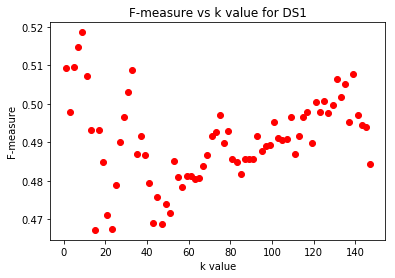

In [10]:
k_vals, accs, precs, recs, fs  = k_NN(positive_train_examples, negative_train_examples, positive_test_examples, negative_test_examples)
plot_K_NN(k_vals, fs)

In [11]:
max_ind = np.argmax(fs)
print(accs[max_ind], precs[max_ind], recs[max_ind], fs[max_ind])

(0.525, 0.5256849315068494, 0.5116666666666667, 0.5185810810810811)
